# Pick Data Analysis

Did not use Time Series analysis because next order pick time is not dependent on previous order pick time


## Goal

**"We manage what we measure, but frequently we measure what is easy."**  

Are there factors that better predict the amount of time needed to pull an order than just previous/current average?

## Background

- Operators in a warehouse are assigned orders to pull
- Each order is a list of 1 or more lines of items
- Items are collected and put into a box/es 
- The pick time starts when the operator starts the order and ends when marked complete by operator
- Operators work full time (8+ hour) shifts or part time (6- hour) shifts
- Turnover in operators is generally high, it is common to have a wide variety of employment tenure in a group
- Training time needed to bring operators average time to pick an order down to the goal varies by operation but is typically consistent within an operation
- Productivity is typically measured as units per hour but definitions of calculation vary widely by operation
- Environmental factors, equipment factors, physical layout, and products also vary widely
- Productivity goals/expectations usually increase year over year (frequently without a specific plan or reasoning to substantiate the change)
- Operator wages are usually directly tied to meeting or exceeding these goals


## Data Setup

**Initial Shape and Columns from Kaggle dataset**

Shape: (159980, 5)
- PH_PICKED: picked by=operator
- PH_PICKSTA: pick start time, converted to timestamp
- PH_PICKEND: pick end time, converted to timestamp
- PH_TOTALLI: total lines on order, measure of order complexity
- PH_TOTALBO: total boxes needed for order, 98% of orders are 1 box

Additional Notes and Fields
- each row is one order
- orders negative time, boxes, or lines were removed
- operator names that appeared less than 10 times in the 4 years of dataset were removed to reduce noise
- retained records from 4 full years represented in dataset 2016, 2017, 2018, and 2019
- orders with more than 1 box were removed for modeling to reduce noise
- calculated days of tenure for each operator
- calculated shift length for each operator
- extracted hour, day, week, month, year 
- calculated pick time per order



## Interesting Findings Summary

## Model Results Summary

**Baseline**      
The MAE (median absolute error) of the baseline (using just the mean pick seconds to predict) is 95 seconds   


**1st Round Models**      
Using 2 features only: total lines per order (a measure of order complexity) and if the order is picked in the last hour of the day:
- the 2 degree polynomial model MAE is 33 seconds on both in sample and out of sample data
- this is a 65% improvement in prediction accuracy using the model instead of the mean to predict pick time

Using only 1 feature: total lines produced nearly identical results (with .01 of previous results) I conclude that the is_hr_18 feature is not needed for modeling.      

Prediction accuracy of pick seconds per order can be improved by 65% just using the total lines on the order as a feature in a 2 degree polynomial feature model.


**2nd Round Models**
Using features of only operator tenure and shift length has same MAE as baseline


**3rd Round Models**      
Using 3 features: total lines per order (a measure of order complexity), binned operator tenure, and part time status does not improve performance from using total lines alone.

The minimal variation between performance of operators based on tenure time and/or FT/PT status in this dataset may be a factor. In a dataset with greater variation these factors might have more predictive impact?

# Wrangle

## Environment setup

In [1]:
import acquire
import prepare
import wrangle_pick
import summarize
import explore
import model

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from datetime import datetime

from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression

from pandas.plotting import register_matplotlib_converters

import warnings
warnings.filterwarnings("ignore")

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

In [2]:
train, validate, test= wrangle_pick.wrangle_pick_data()
train.shape, validate.shape, test.shape

Acquire: downloading raw data files...
Acquire: Completed!
Prepare: Cleaning acquired data...
Prepare: Completed!


((96634, 16), (17054, 16), (20063, 16))

In [3]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [4]:
# found that Xy function was changing original train, validate, test
# try creating copies first so that original are uneffected
X_train = train.copy()
X_validate = validate.copy()
X_test = test.copy()

In [5]:
# exploration of train shows 2% of orders are more than 1 box, dropping these to reduce noise for mvp
X_train_exp, X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle_pick.createXy(X_train, X_validate, X_test)

X_train_exp.shape, X_train.shape, X_validate.shape, X_test.shape, y_train.shape, y_validate.shape, y_test.shape

((94461, 16),
 (94461, 15),
 (16693, 15),
 (19588, 15),
 (94461, 1),
 (16693, 1),
 (19588, 1))

In [6]:
train.shape, X_train_exp.shape, X_train.shape

((96634, 16), (94461, 16), (94461, 15))

In [7]:
# create df for explore where orders with more than 1 box are included
exp = train.copy()

In [8]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   operator       96634 non-null  object         
 1   total_lines    96634 non-null  int64          
 2   total_boxes    96634 non-null  int64          
 3   start          96634 non-null  datetime64[ns] 
 4   end            96634 non-null  datetime64[ns] 
 5   pick_time      96634 non-null  timedelta64[ns]
 6   pick_seconds   96634 non-null  int64          
 7   day            96634 non-null  int64          
 8   day_name       96634 non-null  object         
 9   year           96634 non-null  int64          
 10  month          96634 non-null  int64          
 11  week           96634 non-null  int64          
 12  hour           96634 non-null  int64          
 13  sec_per_box    96634 non-null  float64        
 14  lines_per_box  96634 non-null  float64        
 1

In [9]:
# create df for time series exploration includes orders with more than 1 box
ts = train.copy()

# Non-TS index Explore

## Prep explore dataframe

In [10]:
exp1 = exp[['total_lines', 'total_boxes', 'pick_seconds', 'operator', 'hour', 'day', 'day_name', 
            'week', 'month', 'year', 'sec_per_box', 'lines_per_box', 'sec_per_line' ]]

In [11]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


In [12]:
exp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96634 entries, 83105 to 136055
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_lines    96634 non-null  int64  
 1   total_boxes    96634 non-null  int64  
 2   pick_seconds   96634 non-null  int64  
 3   operator       96634 non-null  object 
 4   hour           96634 non-null  int64  
 5   day            96634 non-null  int64  
 6   day_name       96634 non-null  object 
 7   week           96634 non-null  int64  
 8   month          96634 non-null  int64  
 9   year           96634 non-null  int64  
 10  sec_per_box    96634 non-null  float64
 11  lines_per_box  96634 non-null  float64
 12  sec_per_line   96634 non-null  float64
dtypes: float64(3), int64(8), object(2)
memory usage: 10.3+ MB


In [13]:
# export this dataframe for exploring in Tableau
exp1.to_csv('exp1.csv')

In [14]:
exp1 = pd.read_csv('exp1.csv', index_col=0)
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


### check for observations where pick_seconds is 0

- none where seconds is 0, 1, or 2 only 3 records where time is 4 seconds

Checking to make sure orders have a minimum time greater than 2 seconds.

In [15]:
exp1[exp1.pick_seconds==3]

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
77421,2,1,3,HB,11,8,Saturday,14,4,2017,3.0,2.0,1.5
78873,2,1,3,IT,13,18,Friday,33,8,2017,3.0,2.0,1.5
25102,2,1,3,DACE,13,29,Friday,4,1,2016,3.0,2.0,1.5
81015,2,1,3,HB,13,9,Thursday,45,11,2017,3.0,2.0,1.5


## create visualizations

**DEFINITIONS**     
- each observation is 1 order to fulfill
- the number of lines is the number of (unique?) items to put in the box
- each order is a minimum of 1 box, though more boxes may be needed
    - check if lines are higher on multiple box orders
    - compare mean pick times for multiple box orders

In [16]:
exp1.head()

,total_lines,total_boxes,pick_seconds,operator,hour,day,day_name,week,month,year,sec_per_box,lines_per_box,sec_per_line
83105,6,1,49,DP,12,10,Friday,10,3,2017,49.0,6.0,8.166667
36339,3,1,95,IVETA,14,31,Tuesday,22,5,2016,95.0,3.0,31.666667
151932,2,1,55,JK,12,11,Saturday,19,5,2019,55.0,2.0,27.500000
87290,2,1,23,IT,12,16,Thursday,46,11,2017,23.0,2.0,11.500000
55936,1,1,38,IT,13,12,Sunday,23,6,2016,38.0,1.0,38.000000


In [17]:
exp1.groupby(['total_boxes']).total_lines.agg(['mean', 'median', 'count'])

,mean,median,count
total_boxes,,,
1,7.949439,4.0,94461
2,12.043898,6.0,1139
3,7.940850,5.0,541
4,6.888235,6.0,170
5,6.793103,6.0,116
6,9.654545,5.0,55
7,7.318182,8.5,22
8,6.772727,5.0,22
9,7.333333,7.0,15


In [18]:
# what is the avg lines for orders with more than 1 box?
avg2plusbox = exp1[exp1.total_boxes >1].total_lines.agg(['mean', 'count'])
# what is the avg line for orders with 1 box?
avg1box = exp1[exp1.total_boxes == 1].total_lines.agg(['mean', 'count'])
# what is the population average?
popavg = exp1.total_lines.agg(['mean', 'count'])
print('average total_lines=', popavg)
print('average lines for orders with 1 box=', avg1box)
print('average lines for orders with 2 or more boxes=', avg2plusbox)

average total_lines= mean         7.993429
count    96634.000000
Name: total_lines, dtype: float64
average lines for orders with 1 box= mean         7.949439
count    94461.000000
Name: total_lines, dtype: float64
average lines for orders with 2 or more boxes= mean        9.90566
count    2173.00000
Name: total_lines, dtype: float64


- there are, relatively, very few orders with more than 1 box (only 2K out of 96K)
- might want to drop observations with more than 1 box for MVP model to reduce noise
- due to the imbalance of data the overall average and 1 box average are nearly the same

### Hypothesis Test 1

Is the variance between the average number of lines for the orders with more than 1 box significantly different from the population average?

Ho: The difference is not significant     
Ha: There is a significant difference between the average number of lines      
alpha = .05 (meaning there 95% confidence variation is not due to random chance)     

The p is less than alpha so the null hypothesis (Ho) is rejected

In [19]:
# use one sample t-test
over1box = exp1[exp1.total_boxes >1].total_lines
popmean = exp1.total_lines.mean()
t, p = explore.ttest_1samp(over1box, popmean)

t= 5.705542127216953
p= 1.3182503622016165e-08
p is less than alpha= True


In [20]:
exp1.groupby(['total_boxes']).pick_seconds.agg(['mean', 'median', 'count'])

,mean,median,count
total_boxes,,,
1,143.845481,75.0,94461
2,354.193152,209.0,1139
3,275.896488,175.0,541
4,234.317647,187.5,170
5,212.965517,181.0,116
6,340.545455,233.0,55
7,269.454545,244.0,22
8,266.272727,219.0,22
9,341.066667,225.0,15


In [21]:
# what is the avg pick time for orders with more than 1 box?
pickavg2plusbox = exp1[exp1.total_boxes >1].pick_seconds.agg(['mean', 'median', 'count'])
# what is the avg pick time for orders with 1 box?
pickavg1box = exp1[exp1.total_boxes == 1].pick_seconds.agg(['mean', 'median', 'count'])
# what is the average pick time?
pickpopavg = exp1.pick_seconds.agg(['mean', 'median', 'count'])
print('average total_lines=')
print(pickpopavg)
print('average lines for orders with 1 box=')
print(pickavg1box)
print('average lines for orders with 2 or more boxes=')
print(pickavg2plusbox)

average total_lines=
mean        147.583149
median       77.000000
count     96634.000000
Name: pick_seconds, dtype: float64
average lines for orders with 1 box=
mean        143.845481
median       75.000000
count     94461.000000
Name: pick_seconds, dtype: float64
average lines for orders with 2 or more boxes=
mean       310.060746
median     195.000000
count     2173.000000
Name: pick_seconds, dtype: float64


### Hypothesis Test 2

Is the variance between the average pick seconds for the orders with more than 1 box significantly different from the population average?

Ho: The difference is not significant     
Ha: There is a significant difference between the average pick seconds for orders with more than 1 box      
alpha = .05 (meaning there 95% confidence variation is not due to random chance)     

The p is less than alpha so the null hypothesis (Ho) is rejected

In [22]:
# use one sample t-test
pover1box = exp1[exp1.total_boxes >1].pick_seconds
ppopmean = exp1.pick_seconds.mean()
t, p = explore.ttest_1samp(pover1box, ppopmean)

t= 18.07771844491187
p= 3.68542433327383e-68
p is less than alpha= True


## Explore variation in pick seconds

- each row is an order, so the pick seconds is per order
- maximum outlier is 8000 seconds, or about 2.2 hours
- plot have y axis limit set to 2000 or about 30 min to reduce the visual impact of the outliers

In [23]:
# For Tableau
exp1.to_csv('explore_all_boxes.csv')
X_train_exp.to_csv('exp_only_1box.csv')

### does the pick seconds vary by hour of day?
- operating hours start at 7a and end at 6p
- lots of outliers
- not much variation until last hour of day
- pattern is the same with only 1 box orders

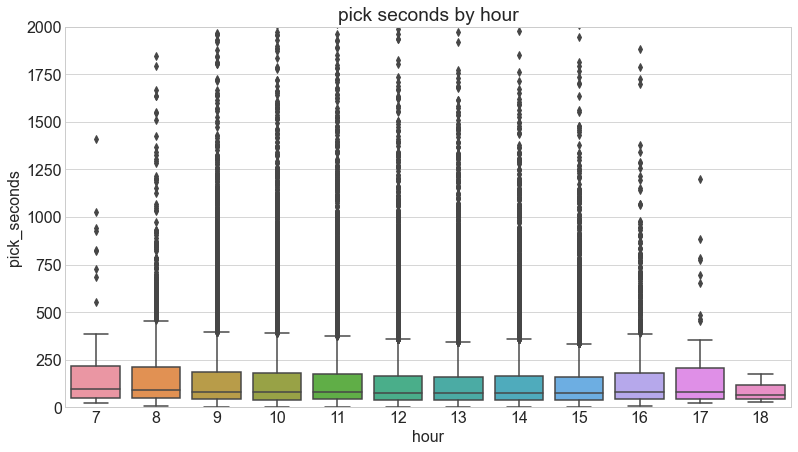

In [24]:
sns.boxplot(data=exp1, y='pick_seconds', x='hour')
plt.title('pick seconds by hour')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

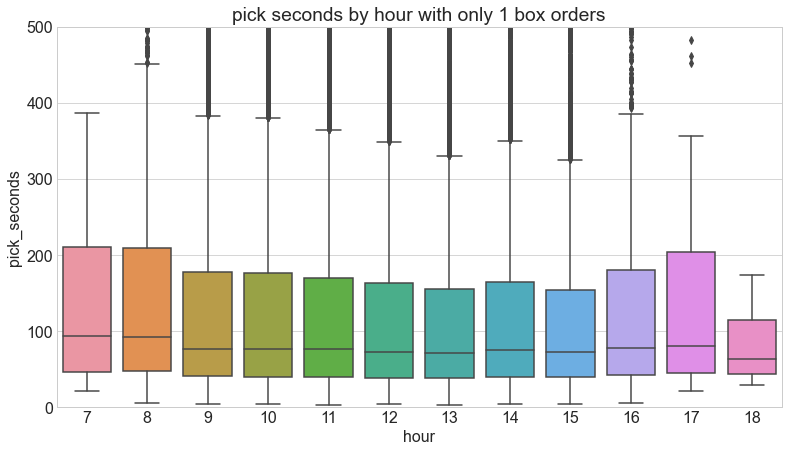

In [25]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='hour')
plt.title('pick seconds by hour with only 1 box orders')
plt.ylim(0, 500)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by day of week?
- not much on average, but there seem to be a lot of outliers?
- pattern is the same with only 1 box orders

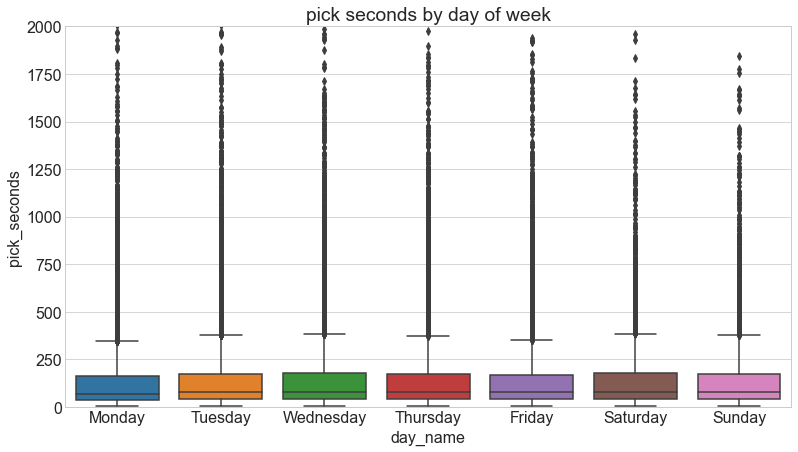

In [26]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='pick_seconds', x='day_name', order=order)
plt.title('pick seconds by day of week')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

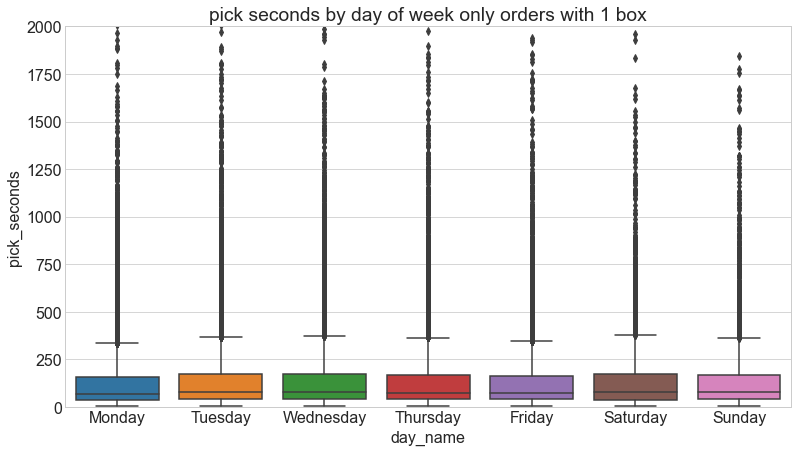

In [27]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=X_train_exp, y='pick_seconds', x='day_name', order=order)
plt.title('pick seconds by day of week only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by day of month?
- no real pattern of variation by day of month
- same with only 1 box orders

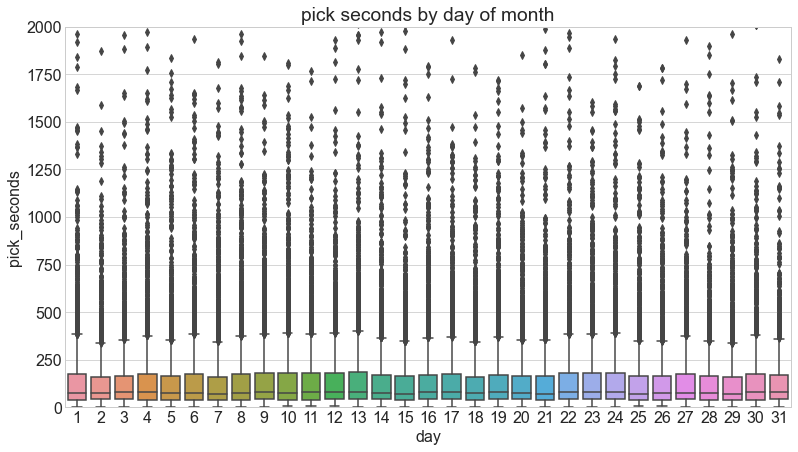

In [28]:
sns.boxplot(data=exp1, y='pick_seconds', x='day')
plt.title('pick seconds by day of month')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

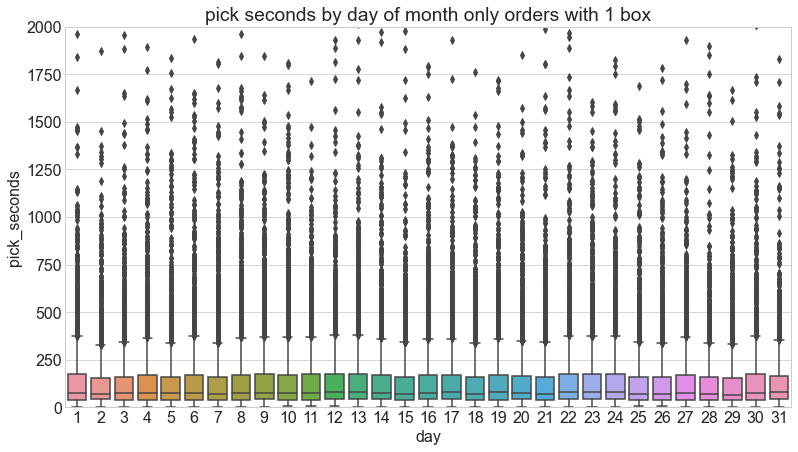

In [29]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='day')
plt.title('pick seconds by day of month only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does do the pick seconds vary by week of year?
- some variation possibly due to complexity of order variation?
- not enough of a consistent patter to use as model feature
- minimal change with only 1 box orders

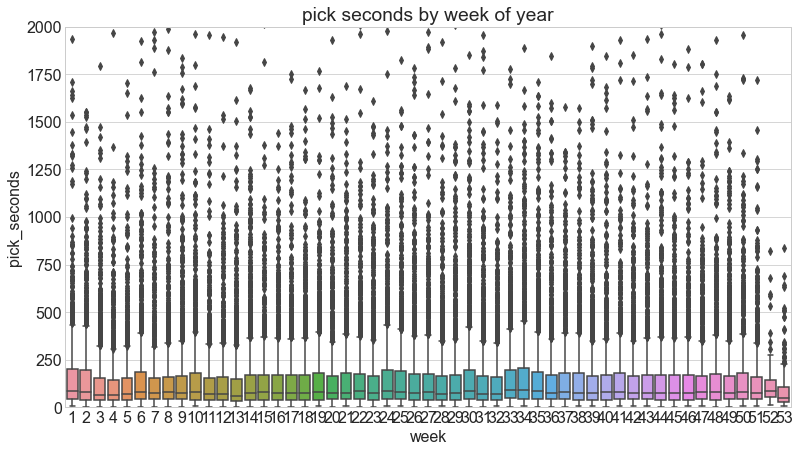

In [30]:
sns.boxplot(data=exp1, y='pick_seconds', x='week')
plt.title('pick seconds by week of year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

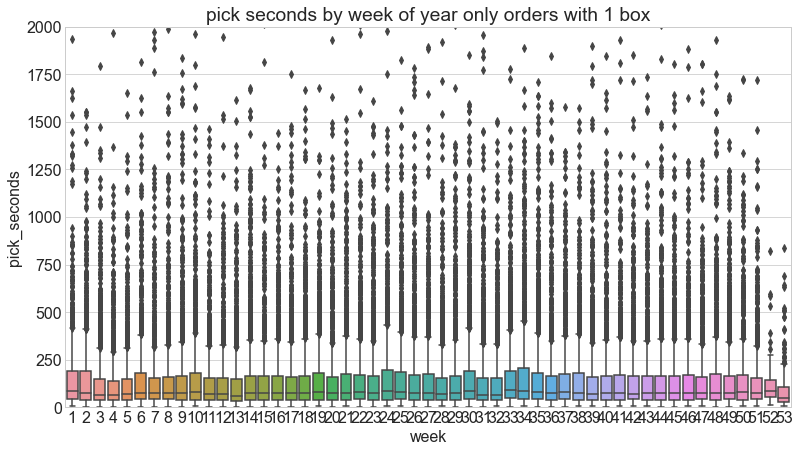

In [31]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='week')
plt.title('pick seconds by week of year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by month of year?
- no variation by month
- no change with only 1 box orders

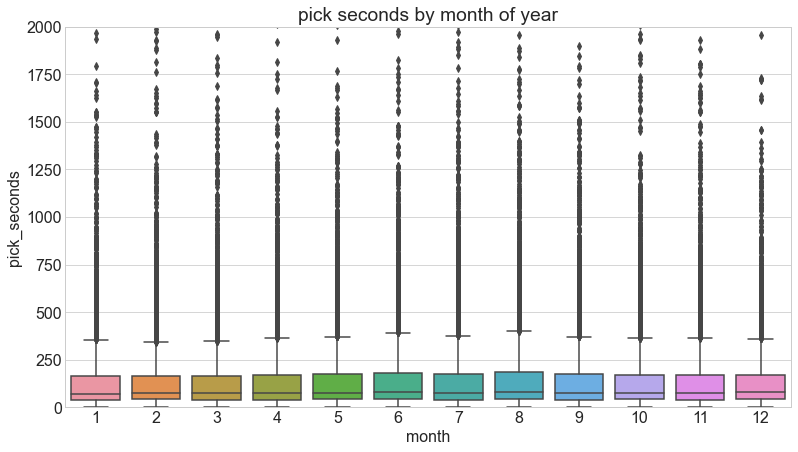

In [32]:
sns.boxplot(data=exp1, y='pick_seconds', x='month')
plt.title('pick seconds by month of year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

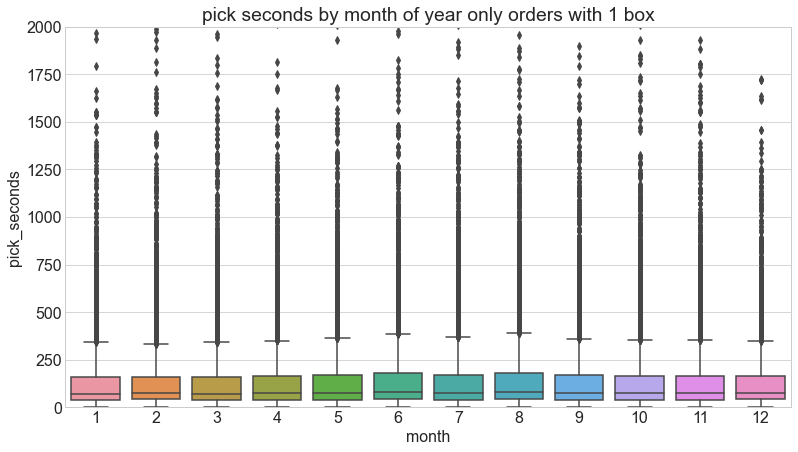

In [33]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='month')
plt.title('pick seconds by month of year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

### does the pick seconds vary by year?
- not really any variation by year

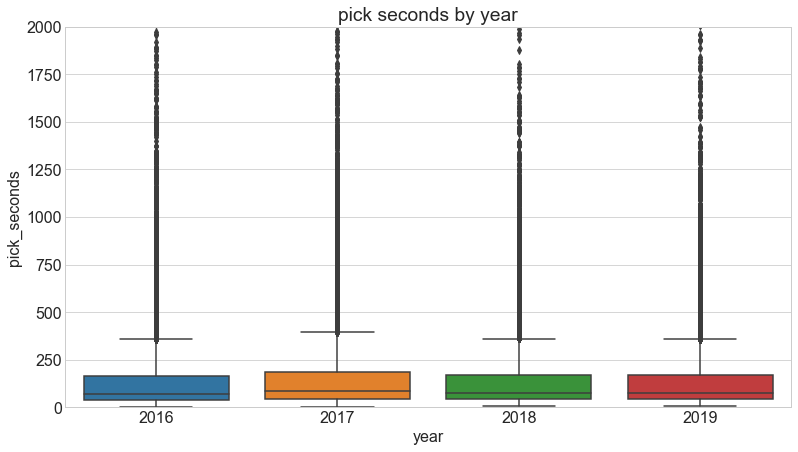

In [34]:
sns.boxplot(data=exp1, y='pick_seconds', x='year')
plt.title('pick seconds by year')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

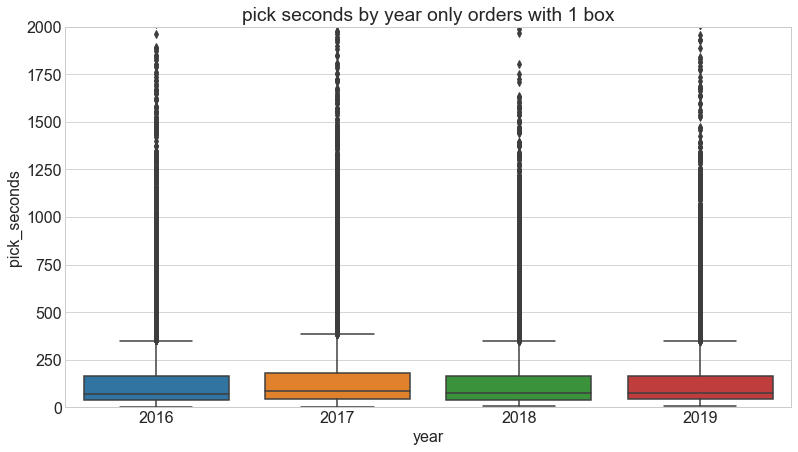

In [35]:
sns.boxplot(data=X_train_exp, y='pick_seconds', x='year')
plt.title('pick seconds by year only orders with 1 box')
plt.ylim(0, 2000)
plt.show()
# note: y axis is limited to 2000 seconds, or about 30 min to reduce visual impact of outliers

## Explore variation in total lines

This impacts the complexity of the orders

### does the total lines vary by hour of day?
- operating hours start at 7a and end at 6p
- lines are lightest at beginning and end of day with a spike around 5p
- note the y axis has been limited to 50 lines to reduce the visual impact of outliers

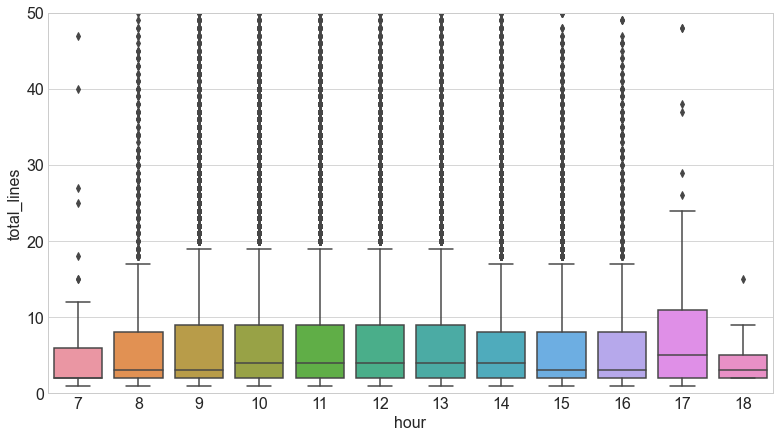

In [36]:
sns.boxplot(data=exp1, y='total_lines', x='hour')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by day of week?
- not much on average, but there seem to be a lot of outliers?

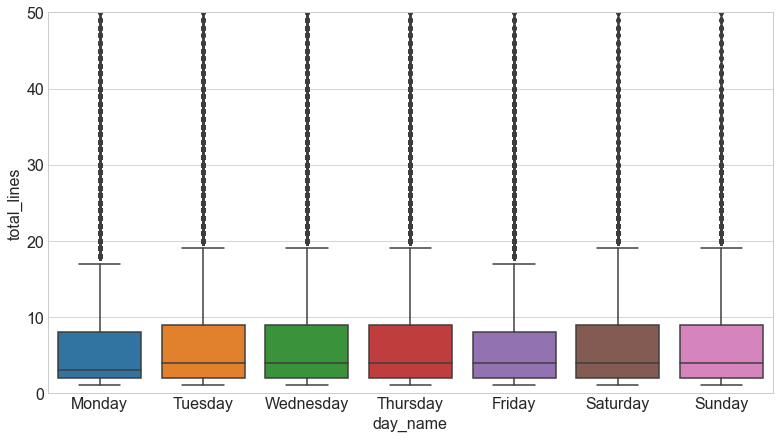

In [37]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_lines', x='day_name', order=order)
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by day of month?
- some variation on average by day of month
- first 4 days of month tend to be higher
- final days of month tend to be lower

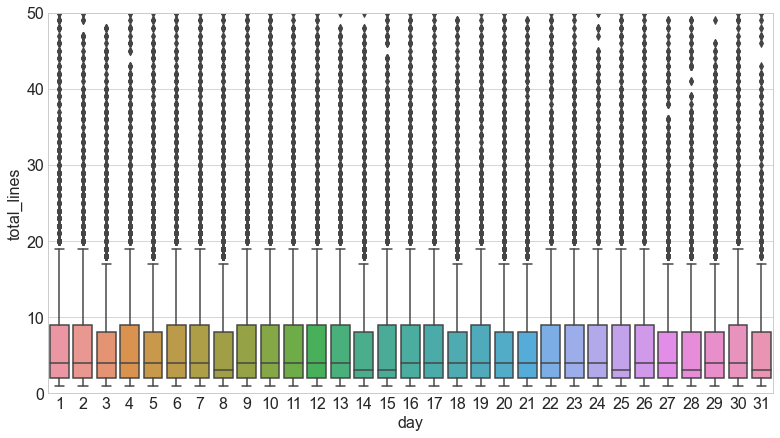

In [38]:
sns.boxplot(data=exp1, y='total_lines', x='day')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by week of year?
- Christmas and Thanksgiving weeks are lighter
- weeks at beginning of months are generally larger and weeks at end of month fewer

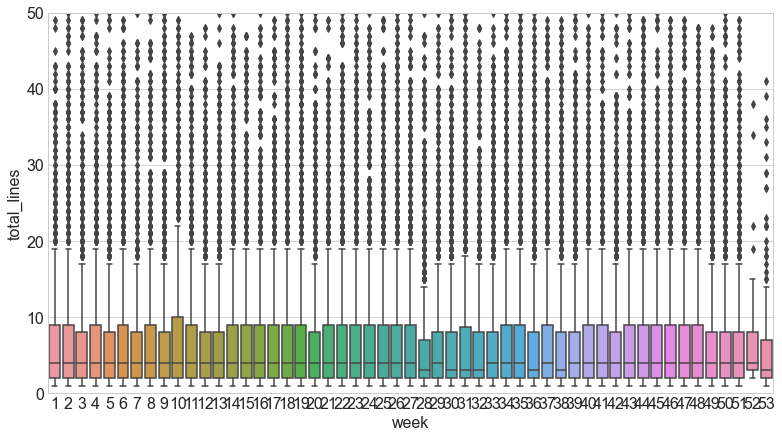

In [39]:
sns.boxplot(data=exp1, y='total_lines', x='week')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by month of year?
- not really any variation by month

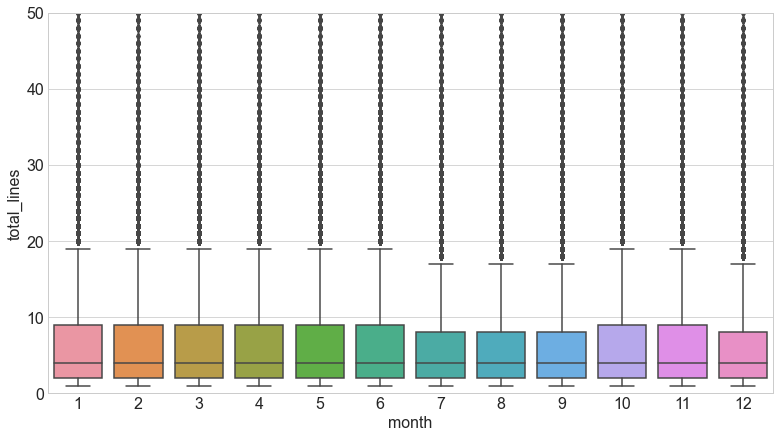

In [40]:
sns.boxplot(data=exp1, y='total_lines', x='month')
plt.ylim(0, 50)
plt.show()
# note: y axis is limited to 50 lines reduce visual impact of outliers

### does the total lines vary by year?
- not really any variation by year

<AxesSubplot:xlabel='year', ylabel='total_lines'>

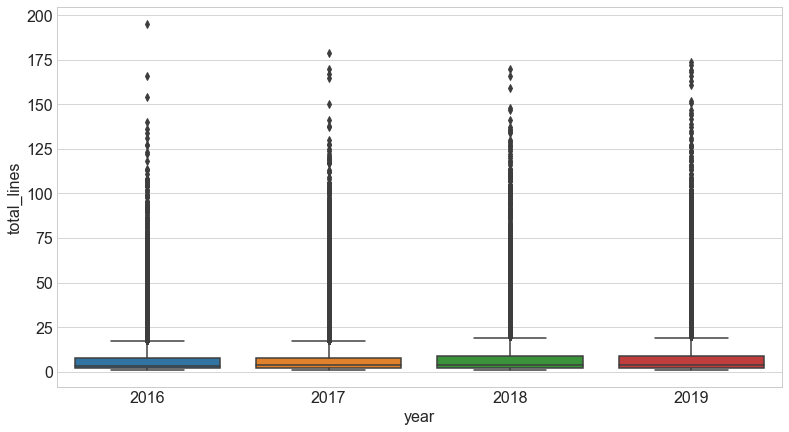

In [41]:
sns.boxplot(data=exp1, y='total_lines', x='year')

### does the total boxes vary by day of week?
- only outliers?
- typically the boxes per pick is 1 so this may not be a good feature for analysis
- might need to treat values <1 as anomalies and remove from dataset?
    - yes, picks with 0 boxes returned 7 observations that are anomalies and will be removed for this round
- visualization also shows total_boxes over 20 as anomalies
- note y axis is limited to 10 boxes

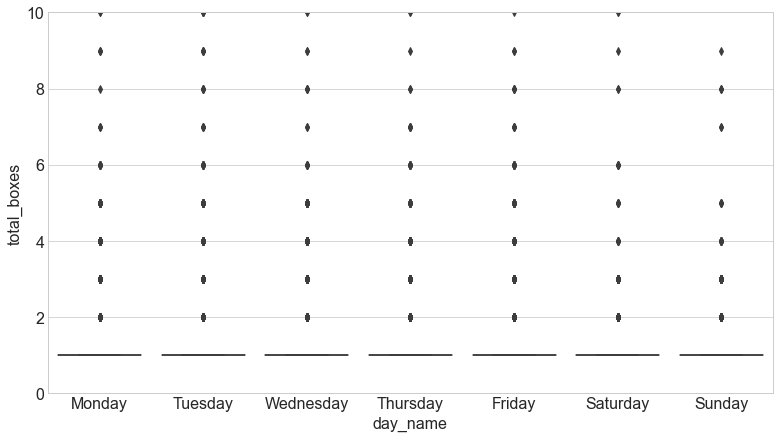

In [42]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=exp1, y='total_boxes', x='day_name', order=order)
plt.ylim(0, 10)
plt.show()
# note: y axis is limited to 10 boxes reduce visual impact of outliers

# Model


- prep for model??
    - drop observations where there is more than 1 box to reduce noise
    - these represent 2% of train dataset
    - YES will drop then create X, y sets then make an X scaled and keep not scaled as well
    
- need to create feature booleen columns
    - only 1 found in data = is hour 18
    
- initial model features total_lines, sec_per_line (scale both of these), and is_hour_18 (boolean)
    - all other columns dropped
    
    
Decided to use Median Absolute Error to evaluate.     
"The median_absolute_error is particularly interesting because it is robust to outliers. The loss is calculated by taking the median of all absolute differences between the target and the prediction."
https://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error

## Create Baseline

- Baseline is the mean pick_seconds per order


In [43]:
baseline = round(y_train.pick_seconds.mean(), 2)
print(f'The average pick seconds per order is', baseline)

The average pick seconds per order is 143.85


In [44]:
# Predict bps_pred_mean (baseline predicted mean)
bps_pred_mean = y_train['pick_seconds'].mean()
y_train['bps_pred_mean'] = bps_pred_mean
y_validate['bps_pred_mean'] = bps_pred_mean
y_test['bps_pred_mean'] = bps_pred_mean

In [45]:
# Median Absolute Error (MAE) recommended for non-normally distributed data
# may not matter giving the law of large numbers?

base_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.bps_pred_mean)
print("MAE using baseline Mean\nTrain/In-Sample: ", round(base_med_abs_train, 2)) 

MAE using baseline Mean
Train/In-Sample:  94.85


In [46]:
evsb = explained_variance_score(y_train.pick_seconds, y_train.bps_pred_mean)
print('Explained Variance = ', round(evsb,3))

Explained Variance =  0.0


## Preprocessing

- create and scale features
- drop unnecessary columns


In [47]:
X_train.head()

,operator,total_lines,total_boxes,start,end,pick_time,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [48]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_pick.model_preprocess1(X_train, X_validate, X_test)
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((94461, 2), (16693, 2), (19588, 2))

In [49]:
X_train_scaled.head()

,total_lines_scaled,is_hr_18
83105,0.025773,0
36339,0.010309,0
151932,0.005155,0
87290,0.005155,0
55936,0.000000,0


## 1st Round Models

Features = total lines, picked in 18th hour of day

### Linear Regression (OLS) Model

- Ordinary Least Squares

In [50]:
# create the model object
lm = LinearRegression(normalize=True)
# no change in result if normalize is True or False

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.pick_seconds)

# predict train
y_train['ps_pred_lm'] = lm.predict(X_train_scaled)

In [51]:
lm_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_lm)
print("MAE using Mean\nTrain/In-Sample: ", round(lm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  37.81


### Tweedie Regressor (GLM) Model

- Generalized Linear Model

In [52]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)
# tried power (1, 2, 3) and alpha .1 and 1; 0 and 0 provide best result

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.pick_seconds)

# predict train
y_train['ps_pred_glm'] = glm.predict(X_train_scaled)


In [53]:
y_train.ps_pred_glm.mean()

143.84548117149964

In [54]:
glm_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_glm)
print("MAE using Mean\nTrain/In-Sample: ", round(glm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  37.81


### Polynomial Feature Model



In [55]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)
# tried 3, 4, 8 degrees but not much different in performance and 2 is less likely to overfit
    
# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.pick_seconds)

# predict train
y_train['ps_pred_pflm2'] = lm2.predict(X_train_degree2)

In [56]:
pflm2_med_abs_train = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_pflm2)
print("MAE using Mean\nTrain/In-Sample: ", round(pflm2_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  32.72


### Validate

Given that the OLS and GLM model performance is identical I will run the OLS and Polynomial Feature models on the validate dataset.

In [57]:
# Linear Regreesion predict validate
y_validate['ps_pred_lm'] = lm.predict(X_validate_scaled)

In [58]:
lm_med_abs_val = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_lm)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(lm_med_abs_val, 2))

MAE using Mean
Train/Out-of-Sample:  37.11


In [59]:
# Polynomial Features predict validate
# predict validate
y_validate['ps_pred_pflm2'] = lm2.predict(X_validate_degree2)

In [60]:
pflm2_med_abs_val = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_pflm2)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm2_med_abs_val, 2))

MAE using Mean
Train/Out-of-Sample:  32.69


### Test

I will run the Polynomial Feature models on the test dataset.

In [61]:
# Polynomial Features predict validate
# predict test
y_test['ps_pred_pflm2'] = lm2.predict(X_test_degree2)

In [62]:
pflm2_med_abs_test = median_absolute_error(y_test.pick_seconds, y_test.ps_pred_pflm2)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm2_med_abs_test, 2))

MAE using Mean
Train/Out-of-Sample:  33.31


In [63]:
evsr1 = explained_variance_score(y_validate.pick_seconds, y_validate.ps_pred_pflm2)
print('Explained Variance = ', round(evsr1,3))

Explained Variance =  0.597


## 1st Round Follow up Models

Is the result the same with only 1 feature?      

Will use OLS and Polynomial models to test this

In [64]:
# copy X_train_scaled and drop column is_hr_18
X_train_scaled2 = X_train_scaled.copy()
X_train_scaled2 = X_train_scaled2.drop(columns='is_hr_18')
X_validate_scaled2 = X_validate_scaled.copy()
X_validate_scaled2 = X_validate_scaled2.drop(columns='is_hr_18')
X_test_scaled2 = X_test_scaled.copy()
X_test_scaled2 = X_test_scaled2.drop(columns='is_hr_18')
X_train_scaled2.head()

,total_lines_scaled
83105,0.025773
36339,0.010309
151932,0.005155
87290,0.005155
55936,0.000000


### Linear Regression (OLS) Model

In [65]:
# create the model object
lm2 = LinearRegression(normalize=True)
# no change in result if normalize is True or False

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled2, y_train.pick_seconds)

# predict train
y_train['ps_pred_lm2'] = lm2.predict(X_train_scaled2)

In [66]:
lm_med_abs_train2 = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_lm2)
print("MAE using Mean\nTrain/In-Sample: ", round(lm_med_abs_train2, 2))

MAE using Mean
Train/In-Sample:  37.8


### Polynomial Feature Model

In [67]:
# make the polynomial features to get a new set of features
pf2 = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
X_train_degree22 = pf2.fit_transform(X_train_scaled2)
# tried 3, 4, 8 degrees but not much different in performance and 2 is less likely to overfit
    
# transform X_validate_scaled & X_test_scaled
X_validate_degree22 = pf2.transform(X_validate_scaled2)
X_test_degree22 = pf2.transform(X_test_scaled2)

# create the model object
lm22 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm22.fit(X_train_degree22, y_train.pick_seconds)

# predict train
y_train['ps_pred_pflm22'] = lm22.predict(X_train_degree22)

In [68]:
pflm22_med_abs_train2 = median_absolute_error(y_train.pick_seconds, y_train.ps_pred_pflm22)
print("MAE using Mean\nTrain/In-Sample: ", round(pflm22_med_abs_train2, 2))

MAE using Mean
Train/In-Sample:  32.74


### Validate


In [69]:
# Linear Regreesion predict validate
y_validate['ps_pred_lm2'] = lm2.predict(X_validate_scaled2)
lm_med_abs_val2 = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_lm2)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(lm_med_abs_val2, 2))

MAE using Mean
Train/Out-of-Sample:  37.11


In [70]:
# Polynomial Features predict validate
# predict validate
y_validate['ps_pred_pflm22'] = lm22.predict(X_validate_degree22)
pflm22_med_abs_val2 = median_absolute_error(y_validate.pick_seconds, y_validate.ps_pred_pflm22)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm22_med_abs_val2, 2))

MAE using Mean
Train/Out-of-Sample:  32.69


### Test

In [71]:
# Polynomial Features predict validate
# predict test
y_test['ps_pred_pflm22'] = lm22.predict(X_test_degree22)
pflm22_med_abs_test2 = median_absolute_error(y_test.pick_seconds, y_test.ps_pred_pflm22)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(pflm22_med_abs_test2, 2))

MAE using Mean
Train/Out-of-Sample:  33.31


In [72]:
# sklearn.metrics.explained_variance_score

evsr1f = explained_variance_score(y_test.pick_seconds, y_test.ps_pred_pflm22)
print('Explained Variance = ', round(evsr1f,3))

Explained Variance =  0.482


## 1st Round Results Summary

The MAE (median absolute error) of the baseline (using just the mean pick seconds to predict) is 95 seconds     

Using 2 features only: total lines per order (a measure of order complexity) and if the order is picked in the last hour of the day:
- the 2 degree polynomial model MAE is 33 seconds on both in sample and out of sample data
- this is a 65% improvement in prediction accuracy using the model instead of the mean to predict pick time

Using only 1 feature: total lines produced nearly identical results (with .01 of previous results) I conclude that the is_hr_18 feature is not needed for modeling.      

Prediction accuracy of pick seconds per order can be improved by 65% just using the total lines on the order as a feature in a 2 degree polynomial feature model.

# Explore by Operator


In [73]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [74]:
train.nunique()

operator            66
total_lines        161
total_boxes         19
start            96603
end              96527
pick_time         1593
pick_seconds      1593
day                 31
day_name             7
year                 4
month               12
week                53
hour                12
sec_per_box       2345
lines_per_box      308
sec_per_line      9611
dtype: int64

In [75]:
# create aggregate df by operator
operdf = train.groupby(['operator'])['total_lines', 'total_boxes',  'pick_seconds', 'start', 'end', 'hour'].\
                        agg({'total_lines': ['sum'], 'total_boxes' : ['sum', 'count'], 'pick_seconds': ['sum'], \
                             'start': ['min'], 'end': ['max'], 'hour': ['min', 'max']})

# use this to unstack the column names
operdf.columns = [' '.join(col).strip() for col in operdf.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

#web_crossover.groupby(['name', 'lesson'])[['sub_lesson']].count()

In [76]:
operdf

,total_lines sum,total_boxes sum,total_boxes count,pick_seconds sum,start min,end max,hour min,hour max
operator,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17
AW,53,95,18,3879,2017-07-08 08:59:00,2017-07-08 11:07:02,8,11
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16
...,...,...,...,...,...,...,...,...
TS,514,130,130,21768,2017-04-08 11:27:08,2017-09-08 09:59:23,8,16
UN3090LABE,149,21,21,2853,2017-03-11 09:10:21,2019-09-04 09:38:56,9,15
W100S/19,89,13,13,2402,2018-11-01 08:33:29,2018-11-01 10:21:26,8,10


In [77]:
operdf = operdf.rename(columns={'total_lines sum': 'total_lines', 'total_boxes sum': 'total_boxes', \
                                'total_boxes count': 'total_orders', 'pick_seconds sum': 'total_pick_sec', \
                                'start min': 'first_day', 'end max': 'last_day', 'hour min': 'shift_start_hour', \
                                'hour max': 'shift_end_hour'
                                })

In [78]:
operdf['tenure_days'] = operdf.last_day - operdf.first_day
operdf['shift_length'] = operdf.shift_end_hour - operdf.shift_start_hour
operdf.tenure_days = operdf.tenure_days.dt.days
#operdf.tenure_days = operdf.tenure_days.replace(0, 1)

In [79]:
# bin by tenure and visualize?
operdf['avg_sec_per_order'] = operdf.total_pick_sec/operdf.total_orders
operdf['avg_line_per_order'] = operdf.total_lines/operdf.total_orders
operdf['avg_box_per_order'] = operdf.total_boxes/operdf.total_orders
operdf['avg_orders_day'] = operdf.total_orders/operdf.tenure_days
operdf

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day
operator,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210
AW,53,95,18,3879,2017-07-08 08:59:00,2017-07-08 11:07:02,8,11,0,3,215.500000,2.944444,5.277778,inf
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TS,514,130,130,21768,2017-04-08 11:27:08,2017-09-08 09:59:23,8,16,152,8,167.446154,3.953846,1.000000,0.855263
UN3090LABE,149,21,21,2853,2017-03-11 09:10:21,2019-09-04 09:38:56,9,15,907,6,135.857143,7.095238,1.000000,0.023153
W100S/19,89,13,13,2402,2018-11-01 08:33:29,2018-11-01 10:21:26,8,10,0,2,184.769231,6.846154,1.000000,inf


In [80]:
# can't have less than 1 day of tenure really
operdf.tenure_days == 0

operator
AH            False
ANDREA        False
AS            False
AW             True
CB            False
              ...  
TS            False
UN3090LABE    False
W100S/19       True
W109/24        True
WH109/18       True
Name: tenure_days, Length: 66, dtype: bool

In [81]:
# create a copy of the dataframe in case this doesn't work
operdf2 = operdf.copy()

In [82]:
# find where the tenure days is 0 and drop those observations
index = operdf2[operdf2.tenure_days == 0].index
operdf2.drop(index, inplace=True)

In [83]:
# create bins based on tenure, anyone not in a bin assign to under 90 days bin
operdf2['tenure_bin'] = pd.cut(operdf2.tenure_days, bins=[0, 90, 365, 730, 1095], labels=[.25, 1, 2, 3])
operdf2.tenure_bin = operdf2.tenure_bin.fillna(.25)
operdf2

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day,tenure_bin
operator,,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944,2.00
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791,1.00
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210,1.00
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926,1.00
DACE,63519,7832,7654,868773,2016-01-02 09:39:12,2016-12-08 14:53:14,8,15,341,7,113.505749,8.298798,1.023256,22.445748,1.00
DE,135,52,52,9141,2018-05-09 08:58:21,2018-09-13 15:03:45,8,14,127,6,175.788462,2.596154,1.000000,0.409449,1.00
DK,310,105,105,14524,2019-09-09 09:02:50,2019-10-09 16:57:22,9,16,30,7,138.323810,2.952381,1.000000,3.500000,0.25
DP,156414,17841,16785,2215790,2017-01-08 09:12:20,2019-12-24 11:12:34,7,15,1080,8,132.010128,9.318677,1.062913,15.541667,3.00
EDITE,13374,1661,1644,194075,2016-01-02 10:01:28,2016-12-02 15:09:27,8,17,335,9,118.050487,8.135036,1.010341,4.907463,1.00


In [84]:
# write operdf2 to csv for Tableau
operdf2.to_csv('operator.csv')

## How does the average pick seconds per order vary by operator tenure?

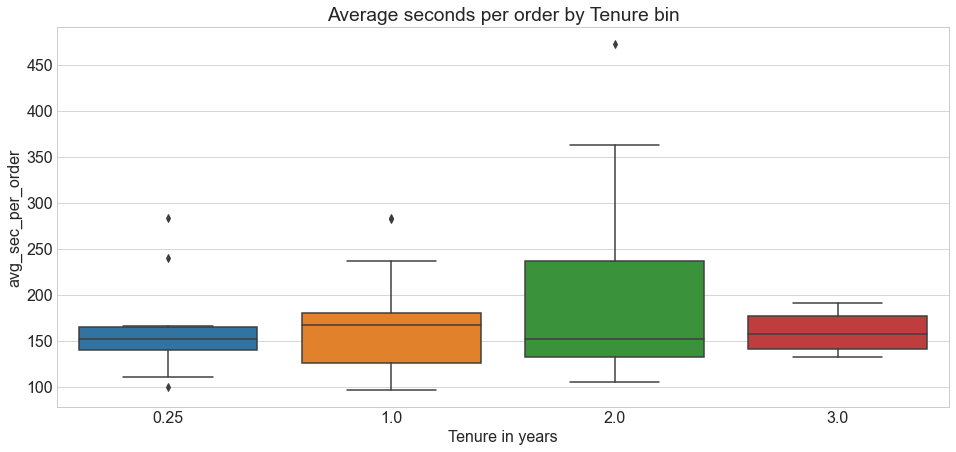

In [85]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_sec_per_order', x='tenure_bin')
plt.title('Average seconds per order by Tenure bin')
plt.xlabel('Tenure in years')
plt.show()

## How does the order complexity (lines per order) vary by operator tenure?

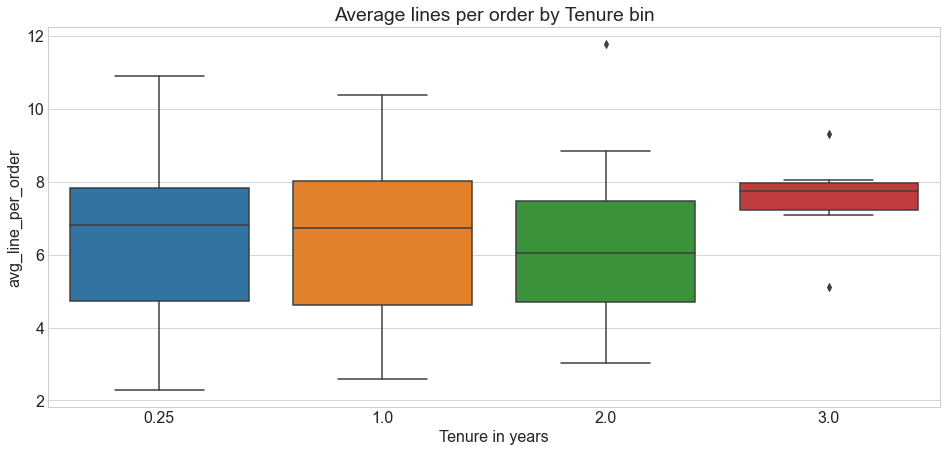

In [86]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_line_per_order', x='tenure_bin')
plt.title('Average lines per order by Tenure bin')
plt.xlabel('Tenure in years')
plt.show()

## How does average orders per day vary by tenure?

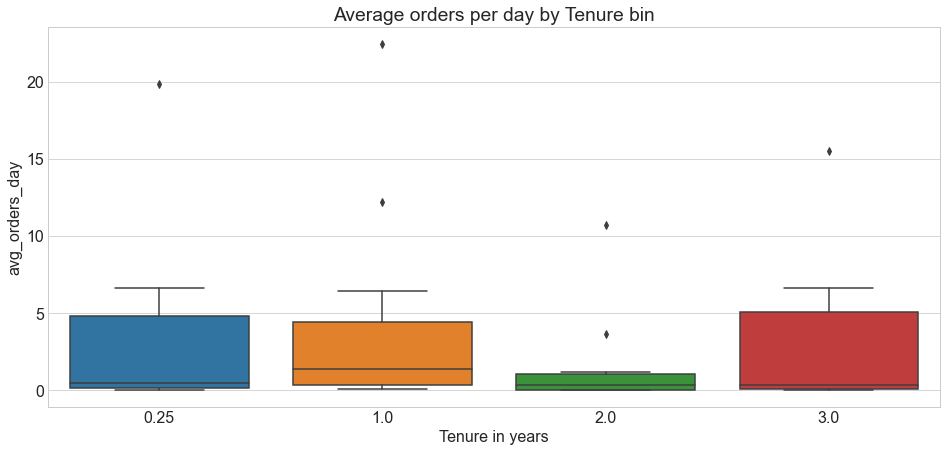

In [87]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_orders_day', x='tenure_bin')
plt.title('Average orders per day by Tenure bin')
plt.xlabel('Tenure in years')
plt.show()

## How does the average boxes per order vary by operator tenure?

- note: this is removed for modeling, as only orders with 1 box are being used in model currently

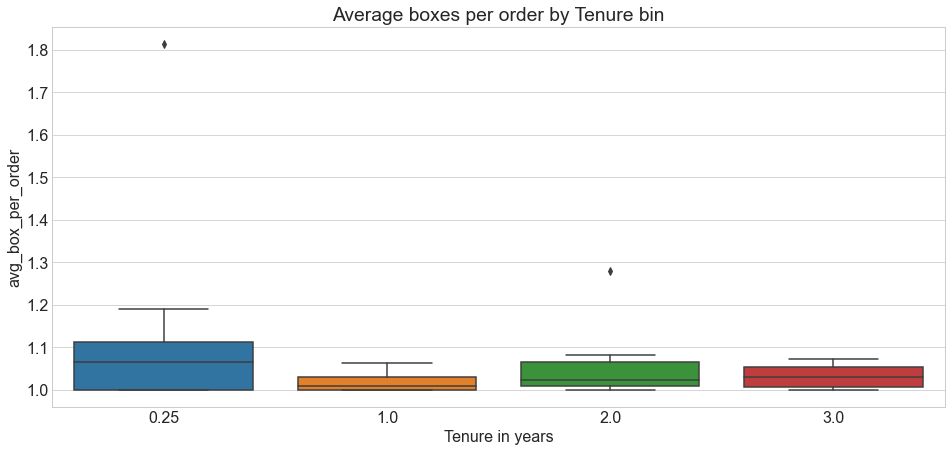

In [88]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_box_per_order', x='tenure_bin')
plt.title('Average boxes per order by Tenure bin')
plt.xlabel('Tenure in years')
plt.show()

In [89]:
# create is_PartTime feature
operdf2['is_part_time'] = np.where(operdf2.shift_length <= 6, 1, 0)
operdf2.head()

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day,tenure_bin,is_part_time
operator,,,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944,2.0,0
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791,1.0,0
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210,1.0,0
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926,1.0,0
DACE,63519,7832,7654,868773,2016-01-02 09:39:12,2016-12-08 14:53:14,8,15,341,7,113.505749,8.298798,1.023256,22.445748,1.0,0


## How does the average pick seconds vary by part time vs full time operator?

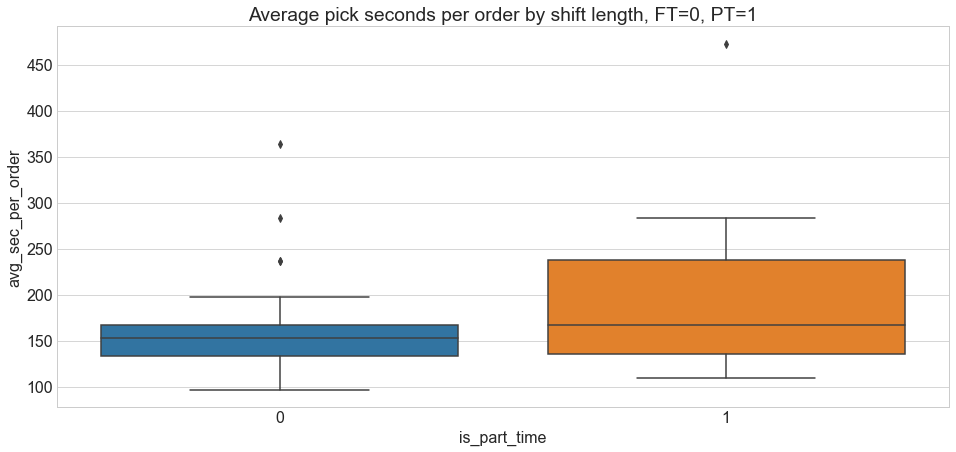

In [90]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_sec_per_order', x='is_part_time')
plt.title('Average pick seconds per order by shift length, FT=0, PT=1')
plt.show()

### What is the % of FT/PT by tenure bin?

In [91]:
shift_tenure = pd.crosstab(operdf2.is_part_time, operdf2.tenure_bin, normalize=True, margins=True)
shift_tenure

tenure_bin,0.25,1.0,2.0,3.0,All
is_part_time,,,,,
0,0.166667,0.229167,0.166667,0.083333,0.645833
1,0.062500,0.166667,0.083333,0.041667,0.354167
All,0.229167,0.395833,0.250000,0.125000,1.000000


## How does average orders per day vary by shift length?

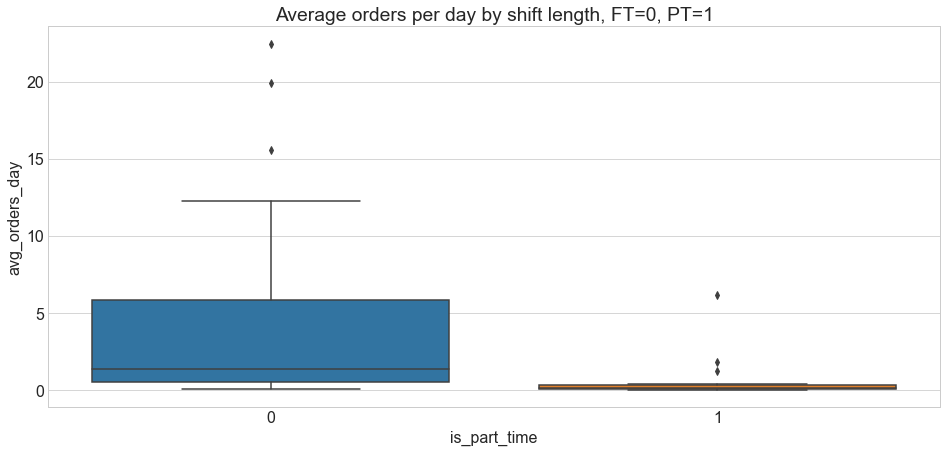

In [92]:
plt.figure(figsize=(16,7))
sns.boxplot(data=operdf2, y='avg_orders_day', x='is_part_time')
plt.title('Average orders per day by shift length, FT=0, PT=1')
plt.show()

## Visualize average pick time by individual operator

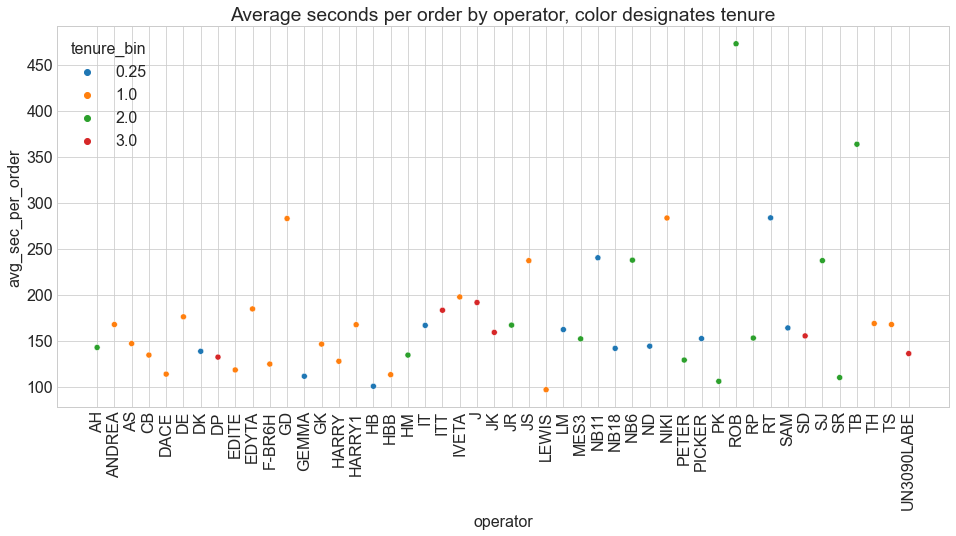

In [93]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=operdf2, y='avg_sec_per_order', x='operator', hue='tenure_bin')
plt.title('Average seconds per order by operator, color designates tenure')
plt.xticks(rotation=90)
plt.show()

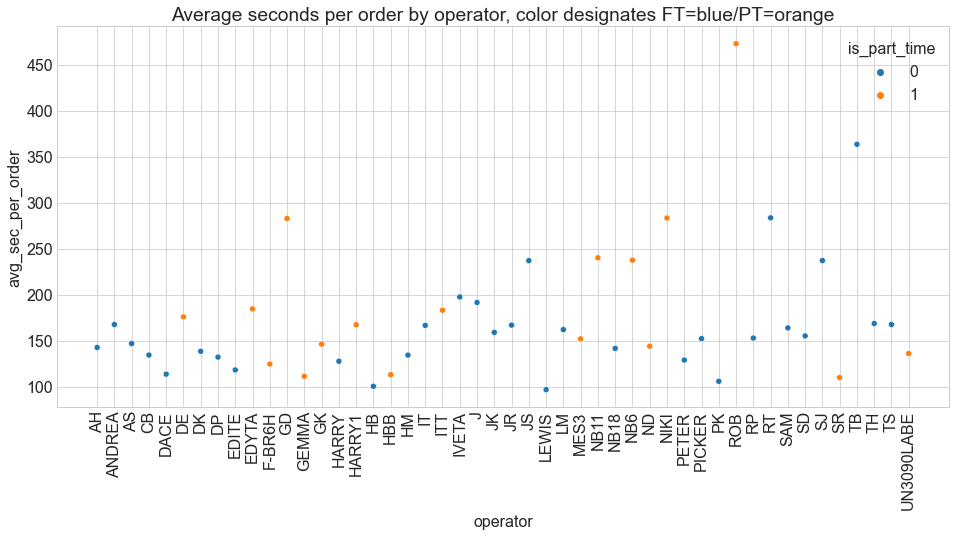

In [94]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=operdf2, y='avg_sec_per_order', x='operator', hue='is_part_time')
plt.title('Average seconds per order by operator, color designates FT=blue/PT=orange')
plt.xticks(rotation=90)
plt.show()

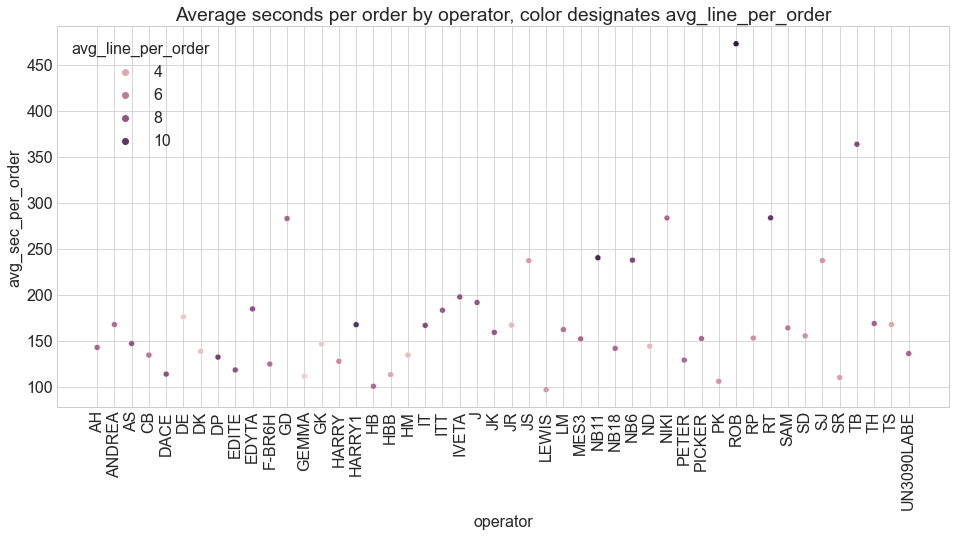

In [95]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=operdf2, y='avg_sec_per_order', x='operator', hue='avg_line_per_order')
plt.title('Average seconds per order by operator, color designates avg_line_per_order')
plt.xticks(rotation=90)
plt.show()

# 2nd round Modeling

## 2nd round preprocessing

- want to add features based on the operator tenure and part time status
- creating copy of X_train so don't overwrite current dataframe


In [96]:
train.head()

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line
83105,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667
36339,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667
151932,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000
87290,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000
55936,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000


In [97]:
operdf2.head()

,total_lines,total_boxes,total_orders,total_pick_sec,first_day,last_day,shift_start_hour,shift_end_hour,tenure_days,shift_length,avg_sec_per_order,avg_line_per_order,avg_box_per_order,avg_orders_day,tenure_bin,is_part_time
operator,,,,,,,,,,,,,,,,
AH,52868,7590,7431,1058670,2016-01-12 09:43:31,2017-12-05 16:12:09,8,16,693,8,142.466694,7.114520,1.021397,10.722944,2.0,0
ANDREA,11836,1811,1756,294002,2016-01-09 10:43:18,2016-12-09 16:42:50,8,17,335,9,167.427107,6.740319,1.031321,5.241791,1.0,0
AS,9093,1205,1134,166383,2016-01-11 09:48:23,2016-12-10 17:21:01,8,17,334,9,146.722222,8.018519,1.062610,3.395210,1.0,0
CB,6036,986,954,128052,2019-01-08 09:01:41,2019-09-08 15:42:23,8,16,243,8,134.226415,6.327044,1.033543,3.925926,1.0,0
DACE,63519,7832,7654,868773,2016-01-02 09:39:12,2016-12-08 14:53:14,8,15,341,7,113.505749,8.298798,1.023256,22.445748,1.0,0


In [98]:
# create column in X train that looks up tenure bin value in operdf2 for the operator list
# create column in X train that looks up is_part_time status of operator in operdf2

# not sure what will happen if merge all columns, but only want tenure bin and is part time
# create copy of operdf2 that has only operator tenure bin and is part time
# https://www.geeksforgeeks.org/how-to-do-a-vlookup-in-python-using-pandas/

oper_mergedf = operdf2[['tenure_bin', 'is_part_time']]
oper_mergedf = oper_mergedf.reset_index()

In [99]:
oper_mergedf.head()

,operator,tenure_bin,is_part_time
0,AH,2.0,0
1,ANDREA,1.0,0
2,AS,1.0,0
3,CB,1.0,0
4,DACE,1.0,0


In [100]:
newtraindf = pd.merge(train, oper_mergedf, on='operator', how='left')
newtraindf
# this will need to be preprocessed before modeling

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line,tenure_bin,is_part_time
0,DP,6,1,2017-03-10 12:33:22,2017-03-10 12:34:11,0 days 00:00:49,49,10,Friday,2017,3,10,12,49.0,6.0,8.166667,3.00,0.0
1,IVETA,3,1,2016-05-31 14:04:57,2016-05-31 14:06:32,0 days 00:01:35,95,31,Tuesday,2016,5,22,14,95.0,3.0,31.666667,1.00,0.0
2,JK,2,1,2019-05-11 12:57:14,2019-05-11 12:58:09,0 days 00:00:55,55,11,Saturday,2019,5,19,12,55.0,2.0,27.500000,3.00,0.0
3,IT,2,1,2017-11-16 12:09:39,2017-11-16 12:10:02,0 days 00:00:23,23,16,Thursday,2017,11,46,12,23.0,2.0,11.500000,0.25,0.0
4,IT,1,1,2016-06-12 13:02:35,2016-06-12 13:03:13,0 days 00:00:38,38,12,Sunday,2016,6,23,13,38.0,1.0,38.000000,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96629,RP,3,1,2019-07-30 10:37:10,2019-07-30 10:38:06,0 days 00:00:56,56,30,Tuesday,2019,7,31,10,56.0,3.0,18.666667,2.00,0.0
96630,HB,8,1,2018-11-10 15:05:54,2018-11-10 15:07:03,0 days 00:01:09,69,10,Saturday,2018,11,45,15,69.0,8.0,8.625000,0.25,0.0
96631,IT,25,1,2018-10-15 16:55:13,2018-10-15 17:02:08,0 days 00:06:55,415,15,Monday,2018,10,42,16,415.0,25.0,16.600000,0.25,0.0
96632,IT,2,1,2019-09-30 14:30:07,2019-09-30 14:32:32,0 days 00:02:25,145,30,Monday,2019,9,40,14,145.0,2.0,72.500000,0.25,0.0


In [101]:
# create validate and test with new features
newvaldf = pd.merge(validate, oper_mergedf, on='operator', how='left') 
newtestdf = pd.merge(test, oper_mergedf, on='operator', how='left')

In [102]:
newtraindf[newtraindf.tenure_bin.isna()]

,operator,total_lines,total_boxes,start,end,pick_time,pick_seconds,day,day_name,year,month,week,hour,sec_per_box,lines_per_box,sec_per_line,tenure_bin,is_part_time
161,W109/24,3,1,2016-04-03 14:53:54,2016-04-03 14:54:29,0 days 00:00:35,35,3,Sunday,2016,4,13,14,35.000000,3.000000,11.666667,NaN,NaN
337,EWA,4,1,2016-08-18 11:04:20,2016-08-18 11:25:24,0 days 00:21:04,1264,18,Thursday,2016,8,33,11,1264.000000,4.000000,316.000000,NaN,NaN
843,CPCV96-12,9,1,2016-10-19 14:16:42,2016-10-19 14:19:45,0 days 00:03:03,183,19,Wednesday,2016,10,42,14,183.000000,9.000000,20.333333,NaN,NaN
930,JESSIE,5,3,2016-02-08 10:31:20,2016-02-08 10:37:48,0 days 00:06:28,388,8,Monday,2016,2,6,10,129.333333,1.666667,77.600000,NaN,NaN
961,EW,8,1,2019-07-18 13:33:03,2019-07-18 13:44:51,0 days 00:11:48,708,18,Thursday,2019,7,29,13,708.000000,8.000000,88.500000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94398,SOS,2,1,2019-06-09 10:03:22,2019-06-09 10:04:58,0 days 00:01:36,96,9,Sunday,2019,6,23,10,96.000000,2.000000,48.000000,NaN,NaN
94677,SOS,2,1,2019-06-09 09:39:23,2019-06-09 09:40:24,0 days 00:01:01,61,9,Sunday,2019,6,23,9,61.000000,2.000000,30.500000,NaN,NaN
94865,WH109/18,2,1,2016-07-07 09:34:46,2016-07-07 09:35:19,0 days 00:00:33,33,7,Thursday,2016,7,27,9,33.000000,2.000000,16.500000,NaN,NaN
95240,IVETTE,3,1,2016-05-13 12:03:49,2016-05-13 12:04:52,0 days 00:01:03,63,13,Friday,2016,5,19,12,63.000000,3.000000,21.000000,NaN,NaN


In [103]:
newvaldf.isna().sum()

operator          0
total_lines       0
total_boxes       0
start             0
end               0
pick_time         0
pick_seconds      0
day               0
day_name          0
year              0
month             0
week              0
hour              0
sec_per_box       0
lines_per_box     0
sec_per_line      0
tenure_bin       52
is_part_time     52
dtype: int64

In [104]:
newtestdf.isna().sum()

operator          0
total_lines       0
total_boxes       0
start             0
end               0
pick_time         0
pick_seconds      0
day               0
day_name          0
year              0
month             0
week              0
hour              0
sec_per_box       0
lines_per_box     0
sec_per_line      0
tenure_bin       53
is_part_time     53
dtype: int64

In [105]:
# after merge there are 236 out of 96K rows with null values in train
# validate and test have 52 and 53 rows with null values
# dropping these observations for modeling
newtraindf = newtraindf.dropna()
newvaldf = newvaldf.dropna()
newtestdf = newtestdf.dropna()

In [106]:
# recheck for nulls
newtraindf.isna().sum()

operator         0
total_lines      0
total_boxes      0
start            0
end              0
pick_time        0
pick_seconds     0
day              0
day_name         0
year             0
month            0
week             0
hour             0
sec_per_box      0
lines_per_box    0
sec_per_line     0
tenure_bin       0
is_part_time     0
dtype: int64

In [107]:
# need to do X y split on new dataframes
newX_train_exp, newX_train, newX_validate, newX_test, newy_train, newy_validate, newy_test = wrangle_pick.createXy(newtraindf, newvaldf, newtestdf)

In [108]:
# preprocess round 2 train, validate, test
r2X_train, r2X_validate, r2X_test = wrangle_pick.model_preprocess2(newX_train, newX_validate, newX_test)

In [109]:
r2X_train.shape, r2X_validate.shape, r2X_test.shape

((94234, 3), (16643, 3), (19538, 3))

## 2nd Round Models

Will use OSL and polynomial features (2 degrees) as before and continue using MAE (Median Absolute Error) for evaluation of the models.

First evaluate using only tenure bin and is part time, follow up with only tenure bin

In [110]:
r2_train_oper_features = r2X_train.drop(columns='total_lines_scaled')
r2_val_oper_features = r2X_validate.drop(columns='total_lines_scaled')
r2_test_oper_features = r2X_test.drop(columns='total_lines_scaled')
r2_train_oper_features.head()

,tenure_bin,is_part_time
0,3.00,0.0
1,1.00,0.0
2,3.00,0.0
3,0.25,0.0
4,0.25,0.0


### Linear Regression (OLS) Model

In [111]:
# create the model object
r2lm = LinearRegression(normalize=True)
# no change in result if normalize is True or False

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
r2lm.fit(r2_train_oper_features, newy_train.pick_seconds)

# predict train
newy_train['ps_pred_r2lm'] = r2lm.predict(r2_train_oper_features)

In [112]:
r2lm_med_abs_train = median_absolute_error(newy_train.pick_seconds, newy_train.ps_pred_r2lm)
print("MAE using Mean\nTrain/In-Sample: ", round(r2lm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  94.29


In [113]:
evsr2 = explained_variance_score(newy_train.pick_seconds, newy_train.ps_pred_r2lm)
print('Explained Variance = ', round(evsr2,3))

Explained Variance =  0.001


### Polynomial Feature Model

In [114]:
# make the polynomial features to get a new set of features
r2pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
r2X_train_degree = r2pf.fit_transform(r2_train_oper_features)
# tried 3, 4, 8 degrees but not much different in performance and 2 is less likely to overfit
    
# transform X_validate_scaled & X_test_scaled
r2X_validate_degree = r2pf.transform(r2_val_oper_features)
r2X_test_degree = r2pf.transform(r2_test_oper_features)

# create the model object
r2lmpf = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
r2lmpf.fit(r2X_train_degree, newy_train.pick_seconds)

# predict train
newy_train['ps_pred_r2pflm'] = r2lmpf.predict(r2X_train_degree)

In [115]:
r2pflm_med_abs_train = median_absolute_error(newy_train.pick_seconds, newy_train.ps_pred_r2pflm)
print("MAE using Mean\nTrain/In-Sample: ", round(r2pflm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  94.4


## 2nd Round Results Summary
using only operator features is about equal to baseline

No need for further validate or test due to poor performance

## 3rd Round Models

For this final set will use total line with operator features

In [116]:
r2X_train.shape, r2X_validate.shape, r2X_test.shape

((94234, 3), (16643, 3), (19538, 3))

### Linear Regression (OLS) Model

In [117]:
# create the model object
r3lm = LinearRegression(normalize=True)
# no change in result if normalize is True or False

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
r3lm.fit(r2X_train, newy_train.pick_seconds)

# predict train
newy_train['ps_pred_r3lm'] = r3lm.predict(r2X_train)

In [118]:
r3lm_med_abs_train = median_absolute_error(newy_train.pick_seconds, newy_train.ps_pred_r3lm)
print("MAE using Mean\nTrain/In-Sample: ", round(r3lm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  37.14


### Polynomial Feature Model

In [119]:
# make the polynomial features to get a new set of features
r3pf = PolynomialFeatures(degree=2)
# fit and transform X_train_scaled
r3X_train_degree = r3pf.fit_transform(r2X_train)
# tried 3, 4, 8 degrees but not much different in performance and 2 is less likely to overfit
    
# transform X_validate_scaled & X_test_scaled
r3X_validate_degree = r3pf.transform(r2X_validate)
r3X_test_degree = r3pf.transform(r2X_test)

# create the model object
r3lmpf = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
r3lmpf.fit(r3X_train_degree, newy_train.pick_seconds)

# predict train
newy_train['ps_pred_r3pflm'] = r3lmpf.predict(r3X_train_degree)

In [120]:
r3pflm_med_abs_train = median_absolute_error(newy_train.pick_seconds, newy_train.ps_pred_r3pflm)
print("MAE using Mean\nTrain/In-Sample: ", round(r3pflm_med_abs_train, 2))

MAE using Mean
Train/In-Sample:  33.28


### Validate


In [121]:
# Linear Regreesion predict validate
newy_validate['r3ps_pred_lm'] = r3lm.predict(r2X_validate)
r3lm_med_abs_val = median_absolute_error(newy_validate.pick_seconds, newy_validate.r3ps_pred_lm)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(r3lm_med_abs_val, 2))

MAE using Mean
Train/Out-of-Sample:  36.63


In [122]:
# Polynomial Features predict validate
# predict validate
newy_validate['r3ps_pred_pflm'] = r3lmpf.predict(r3X_validate_degree)
r3pflm_med_abs_val = median_absolute_error(newy_validate.pick_seconds, newy_validate.r3ps_pred_pflm)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(r3pflm_med_abs_val, 2))

MAE using Mean
Train/Out-of-Sample:  33.35


### Test

In [123]:
# Polynomial Features predict validate
# predict test
newy_test['r3ps_pred_pflm'] = r3lmpf.predict(r3X_test_degree)
r3pflm_med_abs_test = median_absolute_error(newy_test.pick_seconds, newy_test.r3ps_pred_pflm)
print("MAE using Mean\nTrain/Out-of-Sample: ", round(r3pflm_med_abs_test, 2))

MAE using Mean
Train/Out-of-Sample:  33.49


In [124]:
evsr3 = explained_variance_score(newy_test.pick_seconds, newy_test.r3ps_pred_pflm)
print('Explained Variance = ', round(evsr3,3))

Explained Variance =  0.557


## 3rd Round Results Summary

The MAE (median absolute error) of the baseline (using just the mean pick seconds to predict) is 95 seconds     

Using 3 features: total lines per order (a measure of order complexity), binned operator tenure, and part time status does not improve performance from using total lines alone.

The minimal variation between performance of operators based on tenure time and/or FT/PT status in this dataset may be a factor. In a dataset with greater variation these factors might have more predictive impact?